In [47]:
import ReadRawMHD as rR
import test_delete_ as test
import numpy as np
import matplotlib.pyplot as plt
import SimpleITK as sitk
import time
t1 = time.time()

In [48]:
# # # # # Input # # # # #
# Input imaging data
sample = 'Pilot3'  # sample folder
file_bone = 'XCT_Icotec_S130672_L5_intact_planned.mhd'  # gray value bone ct scan
file_inst = 'ICOTEC_S130672_L5_implants_XCTres.mhd'  # segmented screw scan

In [49]:
# # # # # Input # # # # #
# Input FEA data
file_stl = 'mesh.stl'
file_dummyMesh = 'mesh.inp'  # contains nodes and elements
file_dummyInp = 'Pilot3_mesh.inp'

In [50]:
# Specify file locations
path_project = '/home/biomech/Documents/01_Icotec/'  # General project folder
path_ct = path_project + '01_Experiments/02_Scans/' + sample + '/04_Registered/'  # Folder of CT data
path_fea = path_project + '02_FEA/99_Tests/' + sample + '/'  # Folder of FEA files
# Include general path for mesh/template later
info = sample + '.txt'  # .txt file containing info about landmarks. Specific structure

In [51]:
# Load data
im0 = sitk.ReadImage(path_ct + file_bone)
imD = rR.load_itk(path_ct + file_inst)
with open(path_ct + info, 'r') as f:
    content = f.read()
ori = content.split('Origin: ')[1].split('\n')[0]
ori = np.array([int(ori.split(' ')[0]), int(ori.split(' ')[1]), int(ori.split(' ')[2])])
p1P = content.split('positive x axis: ')[1].split('\n')[0]
p1P = np.array([int(p1P.split(' ')[0]), int(p1P.split(' ')[1]), int(p1P.split(' ')[2])])
p1N = content.split('negative x axis: ')[1].split('\n')[0]
p1N = np.array([int(p1N.split(' ')[0]), int(p1N.split(' ')[1]), int(p1N.split(' ')[2])])

In [52]:
# # # # # Input # # # # #
# Define screw vector
lineT = rR.axis3D(imD[0], 670, 1100, 'x')  # if starting from screw tip towards head, add (-) in next line
v3 = -lineT.vector  # z-axis = screw axis, found by function. Specify +/-!!

In [53]:
# Compute matrix
v2 = np.cross(p1P-p1N, v3)/np.linalg.norm(np.cross(p1P-p1N, v3))  # y-axis
v1 = np.cross(v2, v3)  # x-axis
M = np.vstack((np.append(v1, ori[0]), np.append(v2, ori[1]), np.append(v3, ori[2]), np.array([0, 0, 0, 1])))

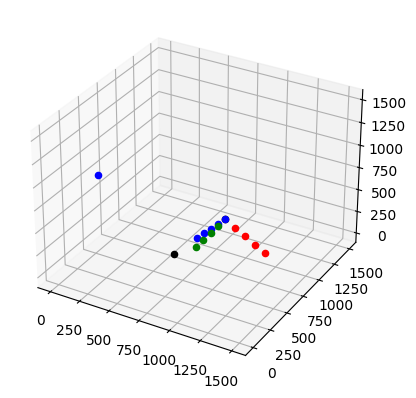

In [54]:
# Check coordinate system
# z-axis (blue) should point from screw head (origin) towards screw tip (dot)
# y-axis should be perpendicular to screw-rotAxis plane and point upwards (against loading direction)
# x-axis: right-handed coordinate system
plt.figure()
ax = plt.axes(projection='3d')
fact = 100
for i in range(-0, 5):
    ax.scatter3D(ori[0]+i*fact*v1[0], ori[1]+i*fact*v1[1], ori[2]+i*fact*v1[2], c='r', alpha=1)
    ax.scatter3D(ori[0]+i*fact*v2[0], ori[1]+i*fact*v2[1], ori[2]+i*fact*v2[2], c='g', alpha=1)
    ax.scatter3D(ori[0]+i*fact*v3[0], ori[1]+i*fact*v3[1], ori[2]+i*fact*v3[2], c='b', alpha=1)
ax.scatter3D(p1P[0], p1P[1], p1P[2], c='b')
ax.scatter3D([0, 1500], [0, 1500], [0, 1500], alpha=0)
ax.scatter3D(686, 480, 177, c='k', alpha=1)  # Ti tip
plt.show()

In [55]:
# to do: proceed with fea part here. create separate script with test_delete functions
bone = {}
bone['SampleName'] = path_ct + file_bone  # File for mapping
stl = path_fea + file_stl
dummyMesh = path_fea + file_dummyMesh
dummyInp = path_fea + file_dummyInp
bone = test.readInpBoneDummy(bone, dummyMesh)  # Read bone mesh from abaqus. Read elements, nodes
bone = test.boneMeshMask(bone, path_fea, stl, 0.0607, sample + '_mask.mhd')  # Create mask from abaqus bone mesh
mask = test.ct.load_itk(path_fea + sample + '_mask.mhd')
bone = test.load_BVTVdata(bone, path_ct + file_bone)
bone['Bone_Mask'] = np.zeros(bone['BVTVscaled'].shape)

 ... read Abaqus file       :  /home/biomech/Documents/01_Icotec/02_FEA/99_Tests/Pilot3/mesh.inp
createEleSets
BoneMeshMask


In [ ]:
imMask = np.transpose(sitk.ReadImage(path_fea + sample + '_mask.mhd'), [2, 1, 0])
print('a')
im0.SetOrigin([0, 0, 0])
print('b')
[theta1, theta2, theta3] = rR.rotation_angles_from_matrix(M[:3, :3], 'zyx')
print('c')
center = np.array([imMask.shape[0]/2, imMask.shape[1]/2,]) * imMask.GetSpacing()
print('d')
trans = M[:3, 3] * imMask.GetSpacing() - center
print('e')

In [ ]:
# Write transformation file
f = open(path_fea + 'transformation_' + sample + 'tfm', "w")
f.write(
    "#Insight Transform File V1.0\n"
    "#Transform 0\n"
    "Transform: CompositeTransform_double_3_3\n"
    "#Transform 1\n"
    "Transform: Euler3DTransform_double_3_3\n"
    "Parameters:  " + f'{theta3}' + " " + f'{theta2-np.pi}' + " " + f'{theta1}'
    + " " + f'{trans[0]}' + " " + f'{trans[1]}' + " " + f'{trans[2]}' + "\n"  # transformation
    "FixedParameters: " + f'{center[0]}' + " " + f'{center[1]}' + " " + f'{center[2]}' + '0'"\n")  # CoR
f.close()

In [ ]:
transform = sitk.REadTransform(path_fea + 'transformation_' + sample + 'tfm')
print('f')
transform_inv = transform.GetInverse()
print('g')
imMask_trans = sitk.Resample(imMask, im0, transform_inv, sitk.sitkNearestNeighbor, 0.0, im0.GetPixelID())
print('h')
sitk.WirteImage(imMask_trans, path_fea + sample + '_mask_trans.mhd')
print('i')
sitk.WriteImage(im0, path_fea + sample + '_CT.mhd')
print('j')

In [ ]:
print('Execution time: ' + str(int((time.time()-t1)/60)) + ' min '+ str(round(np.mod(time.time()-t1, 60), 1)) + ' sec.')